In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
from matplotlib.path import Path
import ast
import pickle
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import networkx as nx
from collections import Counter

In [2]:
def find_points(art):
    x, y = np.meshgrid(np.arange(2000), np.arange(2000)) # make a canvas with coordinates
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T 

    p = Path(art) # make a polygon
    grid = p.contains_points(points,radius = 0)
    mask = grid.reshape(2000,2000) # now you have a mask with points inside a polygon
    x,y = mask.nonzero()
    coords = []
    for xc,yc in zip(x,y):
        coords.append((xc,yc))
    return coords

### arts defined by lists

In [8]:
space_duck  = [[342, 1699], [338, 1703], [333, 1735], [333, 1742], [331, 1742], [330, 1754], [325, 1753], [325, 1747], [321, 1746], [316, 1745], [310, 1745], [293, 1748], [290, 1751], [290, 1755], [291, 1756], [292, 1762], [296, 1766], [303, 1766], [308, 1763], [311, 1763], [313, 1761], [319, 1761], [319, 1757], [322, 1757], [325, 1753], [330, 1753], [333, 1762], [328, 1763], [321, 1768], [316, 1771], [315, 1775], [300, 1782], [297, 1785], [296, 1791], [295, 1792], [295, 1807], [299, 1814], [304, 1815], [311, 1817], [316, 1817], [323, 1819], [326, 1820], [329, 1823], [332, 1824], [336, 1829], [342, 1830], [344, 1832], [346, 1832], [346, 1850], [311, 1850], [311, 1861], [371, 1861], [371, 1850], [346, 1850], [346, 1832], [356, 1832], [365, 1826], [369, 1822], [371, 1814], [374, 1786], [371, 1784], [371, 1782], [365, 1778], [365, 1776], [369, 1776], [376, 1766], [378, 1766], [378, 1774], [383, 1778], [385, 1779], [395, 1779], [400, 1773], [400, 1764], [396, 1760], [391, 1759], [389, 1757], [383, 1757], [379, 1762], [378, 1766], [376, 1766], [376, 1763], [378, 1760], [378, 1753], [379, 1751], [379, 1742], [378, 1741], [378, 1721], [375, 1716], [375, 1712], [371, 1705], [362, 1700], [360, 1699], [341, 1699]]
pufferfish_pond = [[1999, 1118], [1870, 1120], [1870, 917], [1999, 917]]
france = [[125, 497], [175, 497], [175, 288], [171, 284], [171, 275], [148, 275], [148, 300], [141, 307], [141, 320], [152, 320], [152, 328], [125, 328], [125, 345], [132, 345], [132, 386], [125, 386]]
butt = [[185, 1928], [183, 1602], [76, 1600], [75, 1930]]
battle_heroes = [[683, 1510], [710, 1553], [707, 1555], [707, 1571], [707, 1573], [697, 1574], [675, 1570], [673, 1591], [638, 1595], [627, 1604], [628, 1678], [733, 1684], [732, 1691], [724, 1696], [718, 1702], [716, 1714], [720, 1726], [728, 1733], [742, 1734], [754, 1728], [758, 1715], [757, 1703], [751, 1695], [741, 1690], [740, 1691], [739, 1684], [750, 1682], [750, 1670], [779, 1669], [786, 1674], [787, 1711], [830, 1713], [829, 1706], [834, 1705], [833, 1697], [843, 1695], [837, 1660], [831, 1652], [831, 1632], [808, 1609], [812, 1601], [810, 1592], [796, 1586], [789, 1586], [760, 1590], [752, 1585], [751, 1560], [758, 1558], [758, 1544], [753, 1545], [752, 1534], [745, 1541], [743, 1547], [733, 1565], [730, 1565], [726, 1563], [723, 1561], [698, 1521], [685, 1510]]

In [10]:
arts = [space_duck,pufferfish_pond,france,butt,battle_heroes]
NUM_ARTS = len(arts)

In [11]:
artworks = {}
id_count = 1
for row in arts:
    coords = row
    artworks[id_count] = coords
    id_count += 1

### arts defined by datafram from artworks_ordered.csv

In [3]:
arts = pd.read_csv("data/artworks_ordered.csv")
arts[:5]

,Unnamed: 0.1,Unnamed: 0,id,name,path,center,area
0,5372,5372,txrg84,Flag of France,"{'109-164, T': [[249, 1469], [0, 1469], [0, 19...","{'109-164, T': [125, 1719]}",124500.0
1,1187,1187,twpyje,Flag of Germany,"{'109-166, T': [[0, 1121], [448, 1121], [447, ...","{'109-166, T': [992, 1148]}",96223.0
2,258,258,000354,The Nordic Union,"{'1-166, T': [[187, 93], [187, 97], [207, 97],...","{'1-166, T': [506, 129]}",89953.5
3,4866,4866,txd8wt,Central Alliance,"{'1-166, T': [[448, 890], [512, 890], [512, 90...","{'1-166, T': [447, 994]}",75325.5
4,7916,7916,ubyhtf,Netherlands,"{'56-166, T': [[297, 13], [297, 35], [886, 35]...","{'56-166, T': [1171, 19]}",54044.0


In [4]:
arts = arts[arts['name'].str.contains('Flag of Germany|Flag of France|Flag of Spain')]
print(len(arts))
arts

15


,Unnamed: 0.1,Unnamed: 0,id,name,path,center,area
0,5372,5372,txrg84,Flag of France,"{'109-164, T': [[249, 1469], [0, 1469], [0, 19...","{'109-164, T': [125, 1719]}",124500.0
1,1187,1187,twpyje,Flag of Germany,"{'109-166, T': [[0, 1121], [448, 1121], [447, ...","{'109-166, T': [992, 1148]}",96223.0
10,6479,6479,tzavbw,Flag of Spain,"{'109-166, T': [[1158, 1491], [1505, 1498], [1...","{'109-166, T': [1327, 1551]}",38713.5
11,961,961,twr8l9,Flag of Germany,"{'56-166, T': [[2000, 829], [1999, 869], [1055...","{'56-166, T': [1525, 850]}",36011.5
20,967,967,twr7u0,Flag of Germany,"{'1-166, T': [[0, 873], [297, 873], [297, 868]...","{'1-166, T': [347, 850]}",28641.0
42,1216,1216,twpuro,Flag of Spain,"{'56-166, T': [[865, 281], [865, 308], [1489, ...","{'56-166, T': [1145, 295]}",17398.0
89,310,310,twpee3,Flag of France,"{'1-165, T': [[125, 497], [175, 497], [175, 28...","{'1-165, T': [152, 397]}",9633.5
136,692,692,twlnhq,Flag of France,"{'56-165, T': [[1129, 730], [1129, 829], [1200...","{'56-165, T': [1163, 777]}",7292.5
238,702,702,twlk86,Flag of France,"{'1-165, T': [[433, 757], [433, 829], [373, 82...","{'1-165, T': [403, 793]}",4320.0
4224,3581,3581,tx5nb9,The Flag of Spain,"{'109-165, T': [[1062, 1590], [1062, 1596], [1...","{'109-165, T': [1076, 1593]}",168.0


In [7]:
#arts = arts[arts['area'] < 5000]
arts =  arts[arts['area'] > 1000]
print(len(arts))
arts


9


,Unnamed: 0.1,Unnamed: 0,id,name,path,center,area
0,5372,5372,txrg84,Flag of France,"{'109-164, T': [[249, 1469], [0, 1469], [0, 19...","{'109-164, T': [125, 1719]}",124500.0
1,1187,1187,twpyje,Flag of Germany,"{'109-166, T': [[0, 1121], [448, 1121], [447, ...","{'109-166, T': [992, 1148]}",96223.0
10,6479,6479,tzavbw,Flag of Spain,"{'109-166, T': [[1158, 1491], [1505, 1498], [1...","{'109-166, T': [1327, 1551]}",38713.5
11,961,961,twr8l9,Flag of Germany,"{'56-166, T': [[2000, 829], [1999, 869], [1055...","{'56-166, T': [1525, 850]}",36011.5
20,967,967,twr7u0,Flag of Germany,"{'1-166, T': [[0, 873], [297, 873], [297, 868]...","{'1-166, T': [347, 850]}",28641.0
42,1216,1216,twpuro,Flag of Spain,"{'56-166, T': [[865, 281], [865, 308], [1489, ...","{'56-166, T': [1145, 295]}",17398.0
89,310,310,twpee3,Flag of France,"{'1-165, T': [[125, 497], [175, 497], [175, 28...","{'1-165, T': [152, 397]}",9633.5
136,692,692,twlnhq,Flag of France,"{'56-165, T': [[1129, 730], [1129, 829], [1200...","{'56-165, T': [1163, 777]}",7292.5
238,702,702,twlk86,Flag of France,"{'1-165, T': [[433, 757], [433, 829], [373, 82...","{'1-165, T': [403, 793]}",4320.0


In [8]:
artworks = {}
id_count = 1
for row in arts.itertuples():
    name = row.name
    path = row.path
    path = ast.literal_eval(path)
    coords = list(path.values())[0]
    artworks[id_count] = coords
    id_count += 1

# no chunks, fastest method

In [9]:
BEGIN = 3270 # da 2 raddoppio
ENDING = 4908
#FIRST_TIMESTAMP = 180 
#LAST_TIMESTAMP_before_WHITE = 4907 sarebbe da capire qual' é l ultimo minuto prima del bianco
#LAST_TIMESTAMP = 5189 sarebbe da capire qual' é l ultimo minuto prima del bianco


df = pd.read_csv(
        'data/reddit_trimmed.csv',
        engine="c",
        dtype={'timestamp':np.uint16,
          'user_id':np.uint32,
          'pixel_color':np.uint8,
          'x':np.uint16,
          'y':np.uint16,})

df = df[df['timestamp'] > BEGIN]
df = df[df['timestamp'] < ENDING]
ltot = len(df)

In [10]:
dict_set = {}
user_actions = {}
for key in artworks.keys():
    dict_set[key] = set(find_points(artworks[key]))
    user_actions[key] = {}

row_counter = 0
for row in df.itertuples():
    user = row.user_id
    x = row.x
    y = row.y
    for s_key in dict_set.keys():
        if (x,y) in dict_set[s_key]:
            if  user in user_actions[s_key]:
                user_actions[s_key][user] = user_actions[s_key][user] + 1 
            else:
                user_actions[s_key][user] = 1
    row_counter = row_counter + 1
    
    if (row_counter % 5e6) == 0:
        print(f'{row_counter / ltot * 100:.2f}')

6.79
13.58
20.37
27.15
33.94
40.73
47.52
54.31
61.10
67.89
74.68
81.46
88.25
95.04


In [11]:
f = open('output/network_france_germany.csv', 'w')

MIN_TILES = 2
counter = 0

for s_key in dict_set.keys():

    for user_key in user_actions[s_key].keys():
        
        if user_actions[s_key][user_key] >= MIN_TILES:
            f.write(str(s_key) + ',' + str(user_key) + ',' + str(user_actions[s_key][user_key]) + '\n')
            counter += 1
f.close()

In [12]:
counter

610546

In [23]:
degin_distri=Counter(user_actions[2].values())

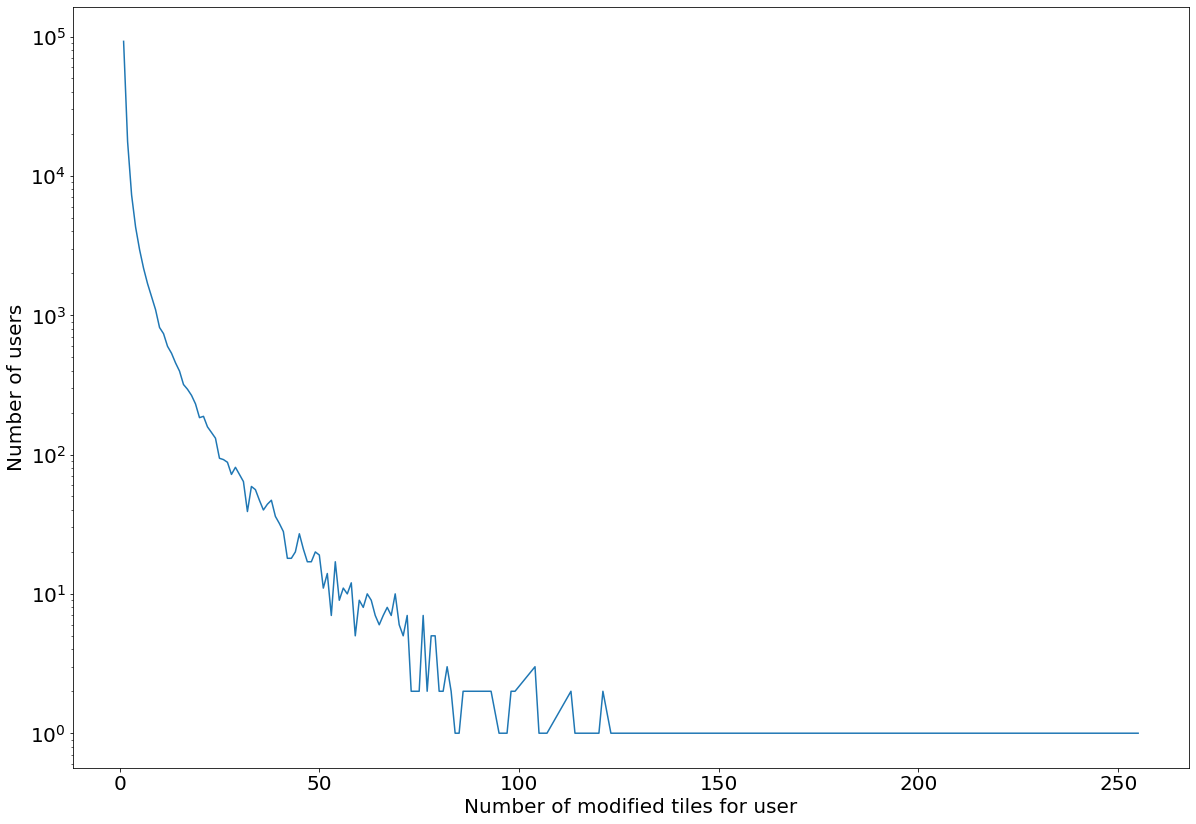

In [24]:
x=[]
y=[]

for i in sorted(degin_distri):   
    x.append(i)
    y.append(degin_distri[i])

plt.figure(figsize=(20,14),)    
plt.plot(x,y)

plt.xlabel('Number of modified tiles for user', fontsize=20)
plt.ylabel('Number of users', fontsize=20)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.yscale('log')
plt.xscale('linear')
#plt.axis([9e-1,500,0.00001,1e-1])
plt.savefig('plot/num_artworks.png',dpi = 300,backend = 'cairo')

In [ ]:
for key in user_actions.keys():
    

# analysis of how many artworks modified by each user

In [32]:
arts = pd.read_csv("data/artworks_ordered.csv")
arts[:5]

,Unnamed: 0.1,Unnamed: 0,id,name,path,center,area
0,5372,5372,txrg84,Flag of France,"{'109-164, T': [[249, 1469], [0, 1469], [0, 19...","{'109-164, T': [125, 1719]}",124500.0
1,1187,1187,twpyje,Flag of Germany,"{'109-166, T': [[0, 1121], [448, 1121], [447, ...","{'109-166, T': [992, 1148]}",96223.0
2,258,258,000354,The Nordic Union,"{'1-166, T': [[187, 93], [187, 97], [207, 97],...","{'1-166, T': [506, 129]}",89953.5
3,4866,4866,txd8wt,Central Alliance,"{'1-166, T': [[448, 890], [512, 890], [512, 90...","{'1-166, T': [447, 994]}",75325.5
4,7916,7916,ubyhtf,Netherlands,"{'56-166, T': [[297, 13], [297, 35], [886, 35]...","{'56-166, T': [1171, 19]}",54044.0


In [33]:
artworks = {}
id_count = 1
for row in arts.itertuples():
    name = row.name
    path = row.path
    path = ast.literal_eval(path)
    coords = list(path.values())[0]
    artworks[id_count] = coords
    id_count += 1

In [ ]:
BEGIN = 3270 # da 2 raddoppio
ENDING = 4908
#FIRST_TIMESTAMP = 180 
#LAST_TIMESTAMP_before_WHITE = 4907 sarebbe da capire qual' é l ultimo minuto prima del bianco
#LAST_TIMESTAMP = 5189 sarebbe da capire qual' é l ultimo minuto prima del bianco


df = pd.read_csv(
        'data/reddit_trimmed.csv',
        engine="c",
        dtype={'timestamp':np.uint16,
          'user_id':np.uint32,
          'pixel_color':np.uint8,
          'x':np.uint16,
          'y':np.uint16,})

df = df[df['timestamp'] > BEGIN]
df = df[df['timestamp'] < ENDING]
ltot = len(df)

In [ ]:
dict_set = {}
user_actions = {}
for key in artworks.keys():
    dict_set[key] = set(find_points(artworks[key]))
    user_actions[key] = {}

row_counter = 0
for row in df.itertuples():
    user = row.user_id
    x = row.x
    y = row.y
    for s_key in dict_set.keys():
        if (x,y) in dict_set[s_key]:
            if  user in user_actions[s_key]:
                user_actions[s_key][user] = user_actions[s_key][user] + 1 
            else:
                user_actions[s_key][user] = 1
    row_counter = row_counter + 1
    
    if (row_counter % 5e6) == 0:
        print(f'{row_counter / ltot * 100:.2f}')

In [31]:
dict_set[1].intersection(dict_set[1],dict_set[2],dict_set[3],dict_set[4])

set()

In [65]:
s = set(user_actions[1].keys())
len(s)

586912

In [66]:
a = set(user_actions[2].keys())
len(a)

39847

In [67]:
len(a.intersection(s))

4893

In [86]:
for key in dict_set.keys():
    a = set(user_actions[key].keys())
    print(len(a.intersection(s)))

586912
63221
14954
37927
13371
21502
4893
9592
1396
161
57
5
321
201
8
